In [17]:
# import libraries

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [18]:
# run the data_processing file to get the training and validation sets

%run ../data_processing.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16626 entries, 0 to 16625
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Administrative  16626 non-null  int64  
 1   Informational   16626 non-null  int64  
 2   ProductRelated  16626 non-null  int64  
 3   ExitRates       16626 non-null  float64
 4   PageValues      16626 non-null  float64
 5   SpecialDay      16626 non-null  float64
 6   Month           16626 non-null  int64  
 7   Region          16626 non-null  int64  
 8   TrafficType     16626 non-null  int64  
 9   VisitorType0    16626 non-null  float64
 10  VisitorType1    16626 non-null  float64
 11  Weekend         16626 non-null  int64  
 12  Revenue         16626 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 1.6 MB


In [19]:
# compile parameters (can be updated for different variations and test)
X_TRAIN = x_train
Y_TRAIN = y_train

X_VALID = x_valid
Y_VALID = y_valid

X_TEST = x_test
Y_TEST = y_test

VALIDATION = (x_valid, y_valid)

ACTIVATION_FUNCTION_OUTPUT = 'softmax'
BATCH_SIZE = 32
EPOCHS = 50
INPUT_DIM = 12
KERNEL_INITIALIZER = 'he_uniform'
LEARNING_RATE = 0.03
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS = ['accuracy']
OPTIMIZER = keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
VERBOSE = 0

# list of activation functions to test (can be updated to test different activation functions)
activation_functions = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign',
                        'tanh', 'selu', 'elu', 'exponential']

# dataframe to hold the loss and accuracy for each activation function
df_result = pd.DataFrame(columns=['activation_function', 'training_loss',
                                  'training_accuracy', 'validation_loss',
                                  'validation_accuracy', 'test_loss',
                                  'test_accuracy', 'time'])

# clears the dataset to avoid redundancy
df_result = df_result.iloc[0:0]

In [20]:
# create a baseline classifier
def create_baseline(act_func):

    # init a sequential NN
    classifier = Sequential()

    # Define the model architecture
    
    # 1st layer - takes in input
    classifier.add(Dense(units=512, kernel_initializer=KERNEL_INITIALIZER,
                         activation=act_func, input_dim=INPUT_DIM))
    # 2nd layer
    classifier.add(Dense(units=128, kernel_initializer=KERNEL_INITIALIZER,
                         activation=act_func))
    # 3rd layer
    classifier.add(Dense(units=96, kernel_initializer=KERNEL_INITIALIZER,
                         activation=act_func))
    # output layer
    classifier.add(Dense(units=2, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION_OUTPUT))

    return classifier

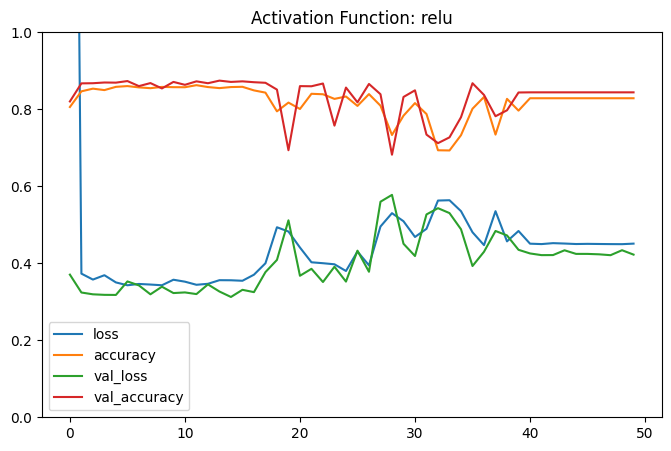

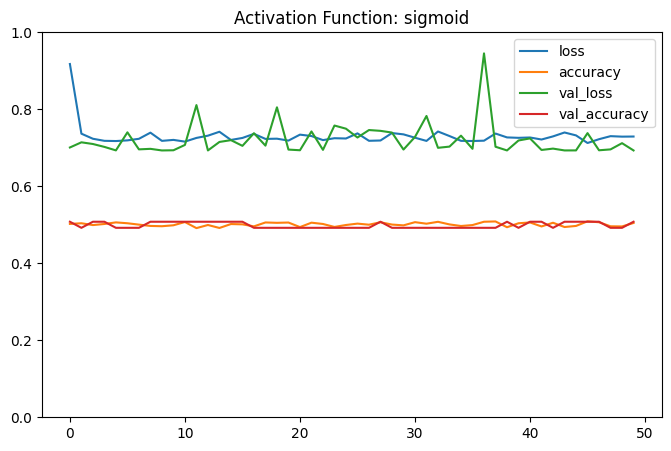

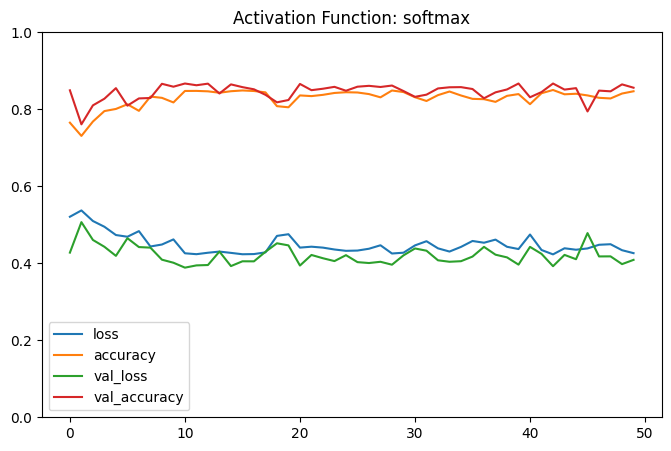

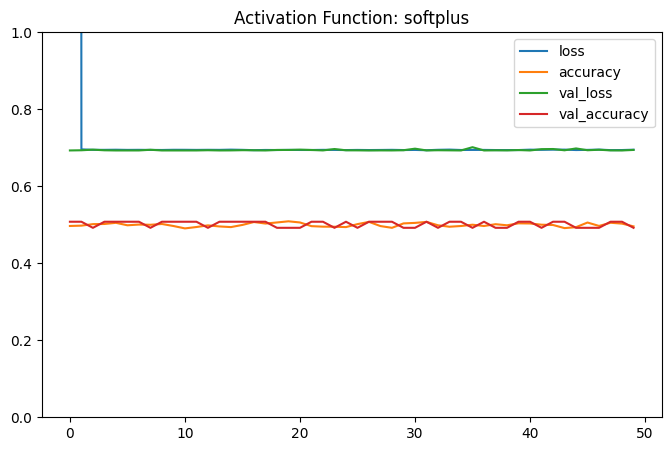

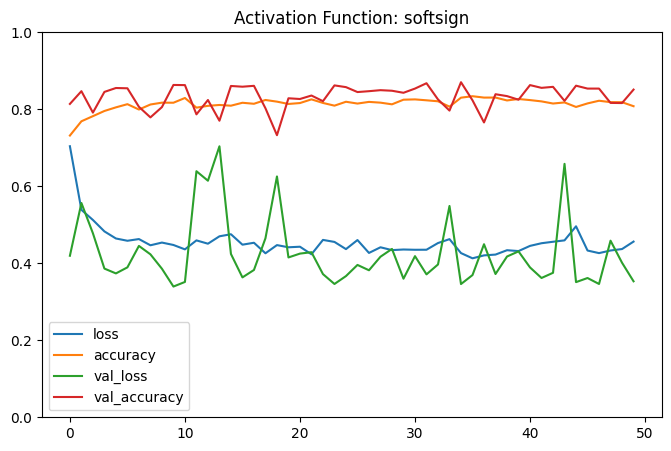

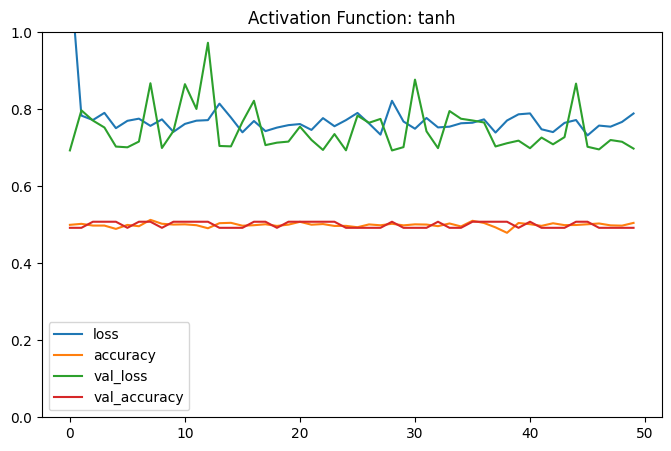

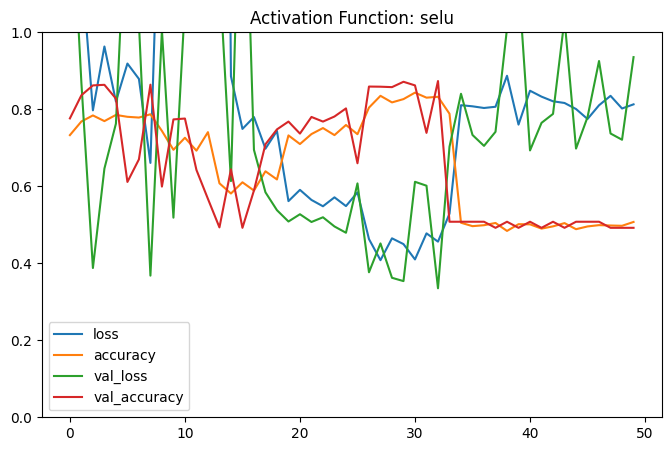

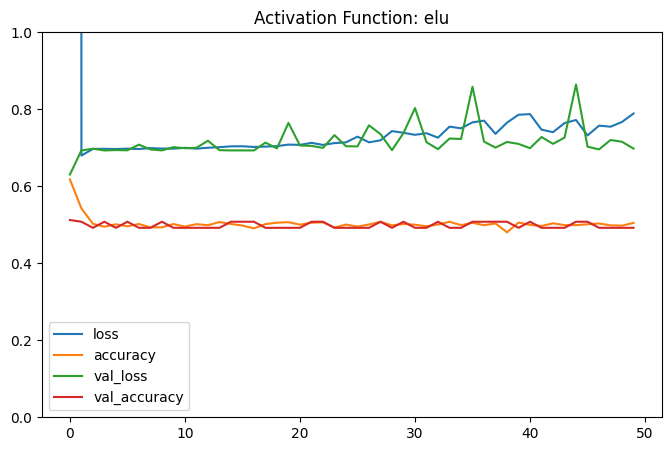

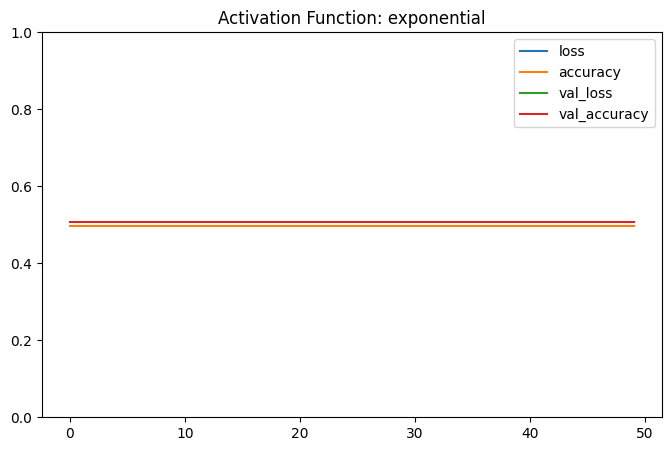

In [21]:
# loop through the activation_functions list to test all the activation functions
for ACTIVATION_FUNCTION in activation_functions:

    start_time = time.time()
    
    # create a baseline model
    model = create_baseline(ACTIVATION_FUNCTION)

    # compile the model with values defined above
    model.compile(optimizer=OPTIMIZER,
                  loss=LOSS_FUNCTION, metrics=METRICS)
    
    # train the model
    history = model.fit(X_TRAIN, Y_TRAIN, validation_data=VALIDATION,
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            verbose=VERBOSE)

    # plot
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid = True
    plt.ylim(0, 1)
    plt.title('Activation Function: ' + str(ACTIVATION_FUNCTION))
    plt.savefig('figures/activation_function_'+ ACTIVATION_FUNCTION +'.png')
    plt.show()

    # evaluation - loss and accuracy
    model_train_loss, model_train_accuracy = model.evaluate(X_TRAIN, Y_TRAIN,
                                                            verbose=VERBOSE)
    model_valid_loss, model_valid_accuracy = model.evaluate(X_VALID, Y_VALID,
                                                            verbose=VERBOSE)
    model_test_loss, model_test_accuracy = model.evaluate(X_TEST, Y_TEST,
                                                          verbose=VERBOSE)
    
    total_time = time.time() - start_time

    # add the evaluation results to the dataset
    df_result = pd.concat([pd.DataFrame([[ACTIVATION_FUNCTION,
                                          model_train_loss,
                                          model_train_accuracy,
                                          model_valid_loss,
                                          model_valid_accuracy,
                                          model_test_loss,
                                          model_test_accuracy,
                                          total_time]],
                                          columns=df_result.columns),
                                          df_result],
                                          ignore_index=True)

In [22]:
# sort the dataframe by test accuracy
df_result = df_result.sort_values(by=['test_accuracy'], ascending=False)

# export the dataframe as a CSV file
df_result.to_csv('activation_function_result.csv', index=True)

# display the evaluation results dataframe
df_result

,activation_function,training_loss,training_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy,time
6,softmax,0.434798,0.839944,0.408860,0.856015,0.440063,0.837342,60.456066
4,softsign,0.385105,0.836090,0.353184,0.851128,0.390215,0.833734,63.485190
8,relu,0.450139,0.828665,0.422502,0.843985,0.458616,0.824113,57.050606
1,elu,0.696293,0.501880,0.697919,0.492105,0.696555,0.500301,60.423520
2,selu,0.921653,0.501880,0.935462,0.492105,0.923884,0.500301,62.119921
3,tanh,0.696292,0.501880,0.697919,0.492105,0.696555,0.500301,55.923820
5,softplus,0.693676,0.501880,0.694389,0.492105,0.693791,0.500301,65.509174
0,exponential,NaN,0.498120,NaN,0.507895,NaN,0.499699,55.926823
7,sigmoid,0.693169,0.498120,0.693094,0.507895,0.693157,0.499699,84.129527


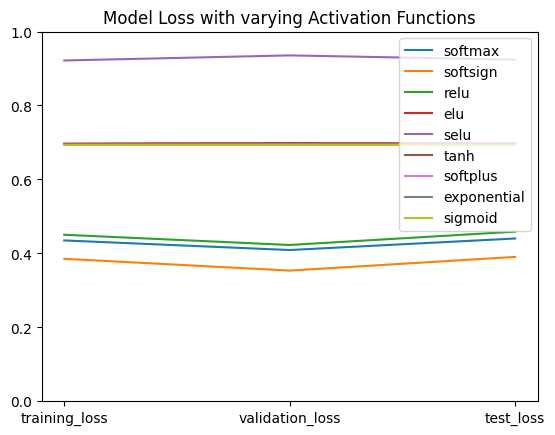

In [23]:
# visualize loss for training, validation and test sets

# x values
x = ['training_loss', 'validation_loss', 'test_loss']

# training and validation loss for each activation function
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_loss'],
                 df_result.iloc[_idx]['validation_loss'],
                 df_result.iloc[_idx]['test_loss']],
                 label=str(df_result.iloc[_idx]['activation_function']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Loss with varying Activation Functions')
plt.legend(loc='upper right')
plt.savefig('figures/loss.png')
plt.show()

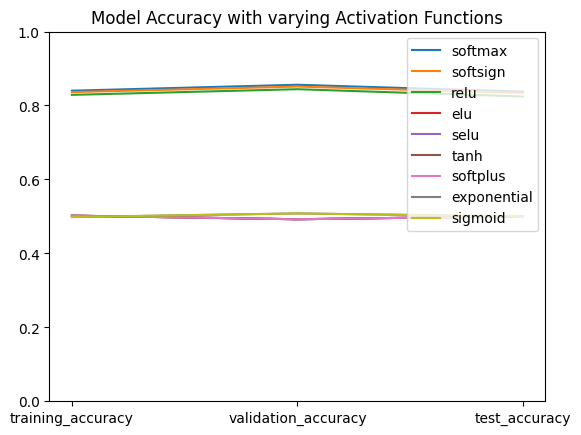

In [24]:
# visualize accuracy for training, validation and test sets

# x values
x = ['training_accuracy', 'validation_accuracy', 'test_accuracy']

# training and validation accuracy for each activation function
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_accuracy'],
                 df_result.iloc[_idx]['validation_accuracy'],
                 df_result.iloc[_idx]['test_accuracy']],
                 label=str(df_result.iloc[_idx]['activation_function']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Accuracy with varying Activation Functions')
plt.legend(loc='upper right')
plt.savefig('figures/accuracy.png')
plt.show()